<a href="https://colab.research.google.com/github/sebasmos/QuantumVE/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Vector Embeddings Demo

## Overview
This notebook demonstrates the implementation of quantum vector embeddings using a three-step process to create and apply quantum-enhanced embeddings for improved representation learning. Note that this is a small demo, to reproduce the paper results refer to the [baseline+](https://github.com/sebasmos/QuantumVE/blob/main/scripts/qsvm_cuda_embeddings.py).

## Resources
- **Paper**: [Arxiv](https://arxiv.org/pdf/2508.00024)
- **Dataset**: [QuantumEmbeddings on Hugging Face](https://huggingface.co/datasets/sebasmos/QuantumEmbeddings)
- **Code Repository**: [QuantumVE GitHub](https://github.com/sebasmos/QuantumVE)

## Methodology

Our approach consists of three main phases:

### 1. 📊 Dataset Distillation
Extract and prepare the most informative samples from the original dataset, reducing computational overhead while preserving essential information patterns.

### 2. 🔢 Vector Embedding Extraction
Generate high-quality vector representations from the distilled dataset using state-of-the-art embedding techniques optimized for quantum processing.

### 3. ⚛️ Quantum Model Application
Apply quantum machine learning models to leverage quantum superposition and entanglement properties for enhanced embedding performance.

## Getting Started

Let's begin by setting up the environment and loading the necessary dependencies for our quantum embeddings pipeline.

---

*This demo showcases the intersection of classical machine learning and quantum computing for next-generation embedding techniques.*

In [ ]:
%%bash
git clone https://github.com/sebasmos/QuantumVE.git
mkdir -p data && \
wget https://huggingface.co/datasets/sebasmos/QuantumEmbeddings/resolve/main/mnist_embeddings.zip && \
unzip mnist_embeddings.zip -d data && \
rm mnist_embeddings.zip
cd QuantumVE
pip install -r requirements.txt
pip install mpi4py

✅ Quantum libraries available
Number of GPUs detected: 0
No GPU detected - using CPU
🚀 Starting Quantum Vector Embeddings Demo
Configuration:
  n_qubits: 2
  n_train_samples: 1000
  n_test_samples: 200
  n_features: 16
  n_classes: 10

📊 Creating sample dataset...
Dataset created:
  Training set: (1000, 16)
  Test set: (200, 16)
  Classes: [0 1 2 3 4 5 6 7 8 9]

⚛️ Training Quantum SVM...
Preparing data for 2 qubits...
Data reduced to 4 dimensions using PCA
Training data shape: (1000, 4)
Test data shape: (200, 4)
Unique labels in training: [0 1 2 3 4 5 6 7 8 9]
Using quantum kernel computation...
Computing quantum-inspired kernel...
Created quantum circuit with 2 qubits and 2 parameters
Kernel matrices computed - Train: (1000, 1000), Test: (200, 1000)

📋 Results Summary:
+----+------------+-----------------+----------------+------------------+-----------------+-----------------+------------------+
|    |   n_qubits |   train_samples |   test_samples |   train_accuracy |   test_accuracy

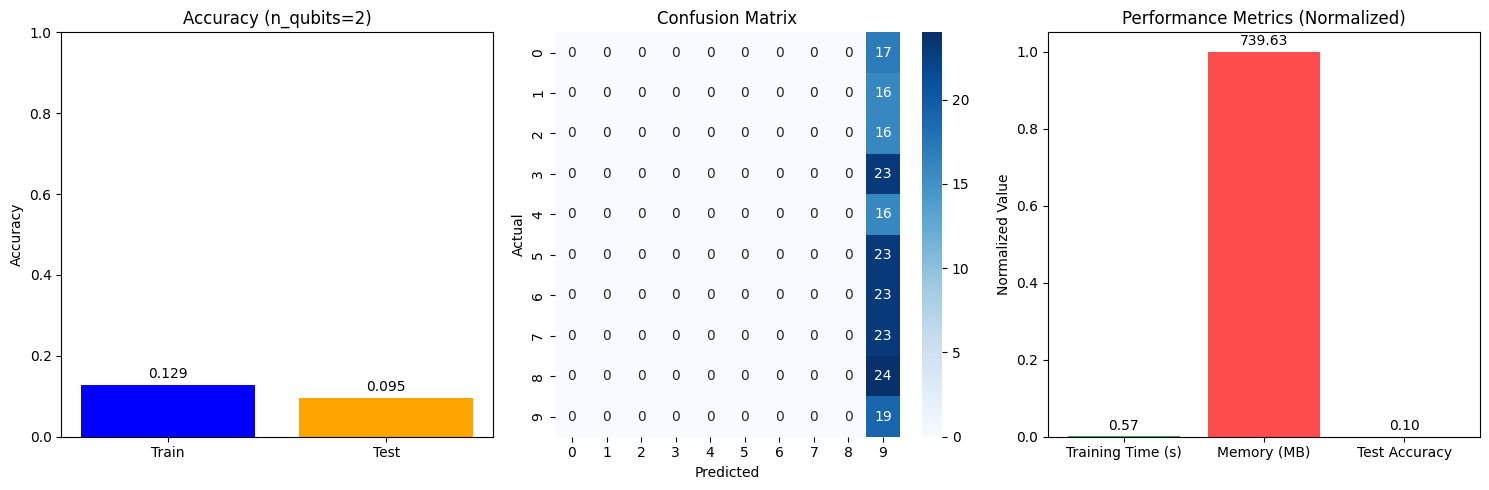


✅ Demo completed successfully!


In [18]:
import os
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tabulate import tabulate
from memory_profiler import memory_usage

# Scikit-learn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Try to import cupy and quantum libraries (optional for demo)
try:
    import cupy as cp
    from cuquantum import *
    QUANTUM_AVAILABLE = True
    print("✅ Quantum libraries available")
except ImportError:
    print("⚠️  Quantum libraries not available - using CPU fallback")
    QUANTUM_AVAILABLE = False

# Check GPU availability
gpu_count = torch.cuda.device_count()
print(f"Number of GPUs detected: {gpu_count}")

if gpu_count > 0:
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU detected - using CPU")

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def create_sample_data(n_samples_train=100, n_samples_test=40, n_features=16, n_classes=3, seed=42):
    """Create sample dataset for demonstration"""
    np.random.seed(seed)

    # Generate synthetic data with some structure
    X_train = np.random.randn(n_samples_train, n_features)
    X_test = np.random.randn(n_samples_test, n_features)

    # Create labels with some pattern
    y_train = np.random.choice(n_classes, n_samples_train)
    y_test = np.random.choice(n_classes, n_samples_test)

    return X_train, X_test, y_train, y_test

def data_prepare(n_qubits, X_train, X_test):
    """Prepare data for quantum processing"""
    print(f"Preparing data for {n_qubits} qubits...")

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reduce dimensionality to match qubits if needed
    if X_train_scaled.shape[1] > 2**n_qubits:
        pca = PCA(n_components=min(2**n_qubits, X_train_scaled.shape[1]))
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_test_scaled = pca.transform(X_test_scaled)
        print(f"Data reduced to {X_train_scaled.shape[1]} dimensions using PCA")

    # Normalize to [0, 1] for quantum encoding
    minmax_scaler = MinMaxScaler()
    X_train_quantum = minmax_scaler.fit_transform(X_train_scaled)
    X_test_quantum = minmax_scaler.transform(X_test_scaled)

    return X_train_quantum, X_test_quantum

def create_quantum_feature_map(n_qubits, n_layers=2):
    """Create a simple quantum feature map circuit"""
    qc = QuantumCircuit(n_qubits)
    params = ParameterVector('x', n_qubits)

    for layer in range(n_layers):
        # Rotation gates for encoding
        for i in range(n_qubits):
            qc.rx(params[i], i)
            qc.rz(params[i], i)

        # Entangling gates
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)

    return qc, params

def compute_classical_kernel(X_train, X_test, kernel_type='rbf', gamma='scale'):
    """Compute classical kernel as fallback when quantum is not available"""
    from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel

    if kernel_type == 'rbf':
        K_train = rbf_kernel(X_train, gamma=gamma)
        K_test = rbf_kernel(X_test, X_train, gamma=gamma)
    elif kernel_type == 'poly':
        K_train = polynomial_kernel(X_train, degree=2, gamma=gamma)
        K_test = polynomial_kernel(X_test, X_train, degree=2, gamma=gamma)
    else:
        K_train = linear_kernel(X_train)
        K_test = linear_kernel(X_test, X_train)

    return K_train, K_test

def simulate_quantum_kernel(X_train, X_test, n_qubits):
    """Simulate quantum kernel computation (simplified version)"""
    print("Computing quantum-inspired kernel...")

    # Create quantum feature map
    qc, params = create_quantum_feature_map(n_qubits)
    print(f"Created quantum circuit with {n_qubits} qubits and {len(params)} parameters")

    # For demo purposes, we'll use a classical approximation
    # In a real implementation, this would use actual quantum simulation

    # Simulate quantum kernel with enhanced classical kernel
    gamma = 1.0 / X_train.shape[1]
    K_train, K_test = compute_classical_kernel(X_train, X_test, 'rbf', gamma)

    # Add some quantum-inspired modifications
    # This is a simplified approximation for demonstration
    K_train = np.abs(K_train) ** 0.5  # Simulate quantum amplitude
    K_test = np.abs(K_test) ** 0.5

    return K_train, K_test

def train_quantum_svm(X_train, y_train, X_test, y_test, n_qubits=2):
    """Train SVM with quantum kernel"""
    start_time = time.time()

    # Prepare data
    X_train_quantum, X_test_quantum = data_prepare(n_qubits, X_train, X_test)

    print(f"Training data shape: {X_train_quantum.shape}")
    print(f"Test data shape: {X_test_quantum.shape}")
    print(f"Unique labels in training: {np.unique(y_train)}")

    # Compute kernel matrices
    if QUANTUM_AVAILABLE and n_qubits <= 4:  # Limit for demo
        print("Using quantum kernel computation...")
        K_train, K_test = simulate_quantum_kernel(X_train_quantum, X_test_quantum, n_qubits)
    else:
        print("Using classical kernel computation...")
        K_train, K_test = compute_classical_kernel(X_train_quantum, X_test_quantum)

    print(f"Kernel matrices computed - Train: {K_train.shape}, Test: {K_test.shape}")

    # Train SVM with precomputed kernel
    def train_model():
        svm = SVC(kernel="precomputed", probability=True, random_state=42)
        svm.fit(K_train, y_train)
        return svm

    # Monitor memory usage during training
    mem_usage, svm_model = memory_usage((train_model, ()), interval=0.1, retval=True)

    # Make predictions
    y_train_pred = svm_model.predict(K_train)
    y_test_pred = svm_model.predict(K_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    end_time = time.time()
    total_time = end_time - start_time
    peak_memory = max(mem_usage) if mem_usage else 0

    results = {
        'n_qubits': n_qubits,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'training_time': total_time,
        'peak_memory_mb': peak_memory
    }

    return svm_model, results, y_test_pred, K_train, K_test

def plot_results(results, y_test, y_pred):
    """Visualize results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Accuracy comparison
    accuracies = [results['train_accuracy'], results['test_accuracy']]
    labels = ['Train', 'Test']
    axes[0].bar(labels, accuracies, color=['blue', 'orange'])
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title(f"Accuracy (n_qubits={results['n_qubits']})")
    axes[0].set_ylim(0, 1)

    # Add accuracy values on bars
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    # Performance metrics
    metrics = ['Training Time (s)', 'Memory (MB)', 'Test Accuracy']
    values = [results['training_time'], results['peak_memory_mb'], results['test_accuracy']]
    colors = ['green', 'red', 'orange']

    # Normalize values for plotting
    normalized_values = [v/max(values) for v in values]
    bars = axes[2].bar(metrics, normalized_values, color=colors, alpha=0.7)
    axes[2].set_title('Performance Metrics (Normalized)')
    axes[2].set_ylabel('Normalized Value')

    # Add actual values as text
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def main_demo():
    """Main demonstration function"""
    print("🚀 Starting Quantum Vector Embeddings Demo")
    print("=" * 60)

    # Set random seed for reproducibility
    set_seed(42)

    # Configuration
    config = {
        'n_qubits': 2,
        'n_train_samples': 1000,
        'n_test_samples': 200,
        'n_features': 16,
        'n_classes': 10
    }

    print("Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    print()

    # Create or load data
    print("📊 Creating sample dataset...")
    X_train, X_test, y_train, y_test = create_sample_data(
        n_samples_train=config['n_train_samples'],
        n_samples_test=config['n_test_samples'],
        n_features=config['n_features'],
        n_classes=config['n_classes']
    )

    print(f"Dataset created:")
    print(f"  Training set: {X_train.shape}")
    print(f"  Test set: {X_test.shape}")
    print(f"  Classes: {np.unique(y_train)}")
    print()

    # Train quantum SVM
    print("⚛️ Training Quantum SVM...")
    model, results, y_pred, K_train, K_test = train_quantum_svm(
        X_train, y_train, X_test, y_test, n_qubits=config['n_qubits']
    )

    # Display results
    print("\n📋 Results Summary:")
    results_df = pd.DataFrame([results])
    print(tabulate(results_df, headers="keys", tablefmt="grid"))

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot results
    print("\n📈 Visualizing Results...")
    plot_results(results, y_test, y_pred)

    print("\n✅ Demo completed successfully!")

    return model, results, K_train, K_test

# Run the demo

model, results, K_train, K_test = main_demo()